In [1]:
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, grey_dilation, grey_erosion, binary_closing, binary_opening, binary_dilation, label, binary_erosion
from skimage.filters import threshold_otsu
from skimage.feature import canny
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

In [2]:
def get_structuring_element_2d_cross(size=3):
    struct = np.zeros((size, size), dtype=bool)
    center = size // 2
    struct[center, :] = True
    struct[:, center] = True
    return struct

def preprocess_slice_median_filter(slice_2d, filter_size=3):
    filtered_slice = median_filter(slice_2d, size=filter_size)
    return filtered_slice

def segment_bright_regions_otsu(slice_2d):
    threshold_value = threshold_otsu(slice_2d)
    binary_mask = slice_2d > threshold_value
    return binary_mask

def refine_binary_mask_opening(binary_mask_2d, struct_size=3, iterations=1):
    struct = get_structuring_element_2d_cross(size=struct_size)
    opened_mask = binary_opening(binary_mask_2d, structure=struct, iterations=iterations)
    return opened_mask

def apply_binary_erosion(binary_mask_2d, struct_size=3, iterations=1):
    struct = get_structuring_element_2d_cross(size=struct_size)
    eroded_mask = binary_erosion(binary_mask_2d, structure=struct, iterations=iterations)
    return eroded_mask

def calculate_slice_area(binary_mask_2d, pixel_width_mm, pixel_height_mm):
    # Count the number of True pixels (or pixels with value 1)
    num_true_pixels = np.sum(binary_mask_2d)
    # Calculate the area of a single pixel
    pixel_area_mm_sq = pixel_width_mm * pixel_height_mm
    # Calculate the total area for the slice
    slice_total_area_mm_sq = num_true_pixels * pixel_area_mm_sq
    return slice_total_area_mm_sq

def watershed_separation_with_parameter(blob_mask, dist_threshold):
    distance = ndimage.distance_transform_edt(blob_mask)
    
    max_dist = distance.max()
    is_blob_valid = max_dist > 0
    
    candidate_markers_mask = (distance > dist_threshold * max_dist) * is_blob_valid
    candidate_labels, num_candidates = ndimage.label(candidate_markers_mask)
    
    has_candidates = num_candidates > 0
    
    areas = np.bincount(candidate_labels.ravel())
    areas[0] = 0
    
    sorted_labels_by_area = np.argsort(areas)[::-1]
    
    padded_labels = np.pad(sorted_labels_by_area, (0, 2), 'constant')
    
    largest_label = padded_labels[0]
    second_largest_label = padded_labels[1]
    
    has_two_markers = (largest_label > 0) * (second_largest_label > 0)
    
    marker1 = (candidate_labels == largest_label)
    marker2 = (candidate_labels == second_largest_label)
    
    markers = (marker1 * 1 + marker2 * 2) * has_two_markers

    labels_ws = watershed(-distance, markers, mask=blob_mask)
    
    area1 = np.sum(labels_ws == 1)
    area2 = np.sum(labels_ws == 2)
    
    return labels_ws, area1, area2

def find_best_split(blob_mask):
    threshold_candidates = np.arange(0.05, 1.0, 0.05)
    stored_results = []
    stored_scores = []

    for threshold in threshold_candidates:
        labels, area1, area2 = watershed_separation_with_parameter(blob_mask, threshold)
        
        is_valid_split = (area1 > 0) * (area2 > 0)
        
        max_val = np.max([area1, area2]) + 1e-6
        min_val = np.min([area1, area2])
        
        balance_score = (min_val / max_val) * is_valid_split
        
        stored_scores.append(balance_score)
        stored_results.append(labels)

    best_index = np.argmax(stored_scores)
    best_segmentation_raw = stored_results[best_index]
    
    # --- START OF NEW POST-PROCESSING STEP ---
    # Analyze the raw watershed output and keep only the two largest regions
    final_areas = np.bincount(best_segmentation_raw.ravel())
    final_areas[0] = 0
    
    sorted_final_labels = np.argsort(final_areas)[::-1]
    padded_final_labels = np.pad(sorted_final_labels, (0, 2), 'constant')
    
    final_label1 = padded_final_labels[0]
    final_label2 = padded_final_labels[1]
    
    # Create the clean final image with only the two largest components
    clean_segmentation = (best_segmentation_raw == final_label1) * 1 + \
                         (best_segmentation_raw == final_label2) * 2
    # --- END OF NEW POST-PROCESSING STEP ---
    
    return clean_segmentation

def calculate_chamber_areas(segmented_mask):
    # Counts the number of pixels belonging to label 1 and label 2
    area_chamber1_pixels = np.sum(segmented_mask == 1)
    area_chamber2_pixels = np.sum(segmented_mask == 2)
    
    # Converts the pixel counts to physical area based on the project's resolution
    resolution_mm = 1.5  #
    area_per_pixel_mm2 = resolution_mm * resolution_mm
    
    area_chamber1_mm2 = area_chamber1_pixels * area_per_pixel_mm2
    area_chamber2_mm2 = area_chamber2_pixels * area_per_pixel_mm2
    
    return area_chamber1_mm2, area_chamber2_mm2

# Datos

In [3]:
with h5py.File('Datos_Proyecto_Final/CMRA_HV1.mat', 'r') as f:
    HV1_bright = f['HV1_bright'][:] 
    HV1_bright = np.transpose(HV1_bright, (2, 1, 0)) # load brightblood 
    
with h5py.File('Datos_Proyecto_Final/CMRA_HV2.mat', 'r') as f:
    HV2_bright = f['HV2_bright'][:] 
    HV2_bright = np.transpose(HV2_bright, (2, 1, 0)) # load brightblood 

# Bright

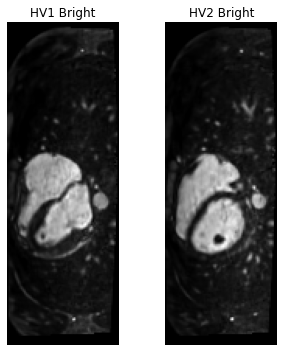

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

hv1_bright_slice = HV1_bright[HV1_bright.shape[0] // 2, :, :]
hv2_bright_slice = HV2_bright[HV2_bright.shape[0] // 2, :, :]

axes[0].imshow(hv1_bright_slice, cmap='gray')
axes[0].set_title('HV1 Bright')
axes[0].axis('off')

axes[1].imshow(hv2_bright_slice, cmap='gray')
axes[1].set_title('HV2 Bright')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Separacion (RA + RV) y (LA + LV)

In [5]:
# Filtro mediana
hv1_bright_slice_processed = preprocess_slice_median_filter(hv1_bright_slice, filter_size=3)
hv2_bright_slice_processed = preprocess_slice_median_filter(hv2_bright_slice, filter_size=3)

# Threshold Otsu
hv1_directly_segmented_bright_regions_roi_initial = segment_bright_regions_otsu(hv1_bright_slice_processed)
hv2_directly_segmented_bright_regions_roi_initial = segment_bright_regions_otsu(hv2_bright_slice_processed)

# Opening
hv1_refined_roi_mask = refine_binary_mask_opening(hv1_directly_segmented_bright_regions_roi_initial, struct_size=7)
hv2_refined_roi_mask = refine_binary_mask_opening(hv2_directly_segmented_bright_regions_roi_initial, struct_size=7)

# Erosion
hv1_separated_blobs_mask_erosion = apply_binary_erosion(hv1_refined_roi_mask, struct_size=3, iterations=2)
hv2_separated_blobs_mask_erosion = apply_binary_erosion(hv2_refined_roi_mask, struct_size=3, iterations=2)

# Label
hv1_labeled_array, hv1_num_components = label(hv1_separated_blobs_mask_erosion)
hv1_ra_rv = (hv1_labeled_array == 1)
hv1_la_lv = (hv1_labeled_array == 2)

hv2_labeled_array, hv2_num_components = label(hv2_separated_blobs_mask_erosion)
hv2_ra_rv = (hv2_labeled_array == 1)
hv2_la_lv = (hv2_labeled_array == 3)

In [6]:
combined_hv1_labels = (hv1_ra_rv * 1) + (hv1_la_lv * 2)
combined_hv2_labels = (hv2_ra_rv * 1) + (hv2_la_lv * 2)

FileNotFoundError: [Errno 2] No such file or directory: 'figuras_avance/label.jpeg'

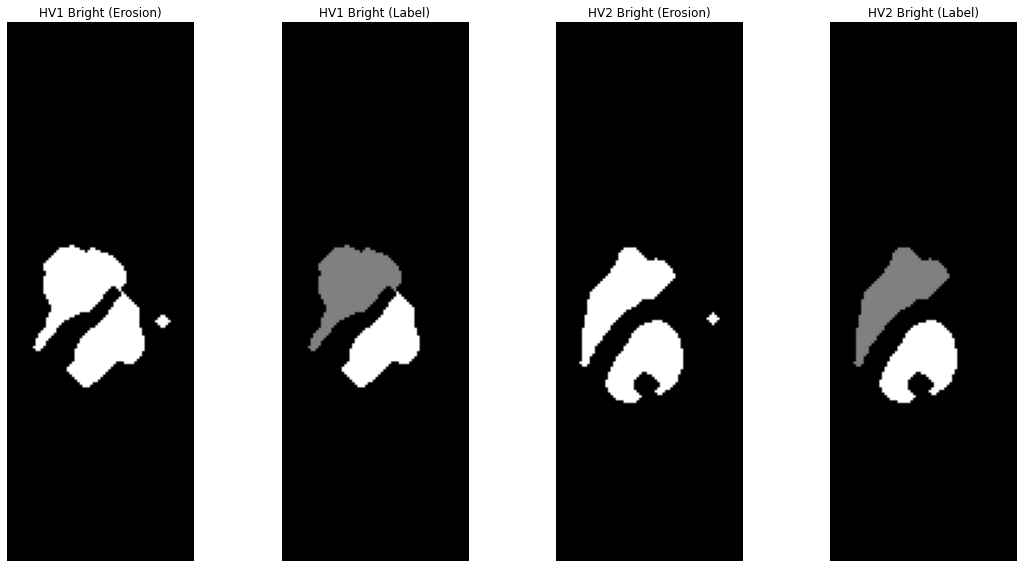

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(16, 8))

axes[0].imshow(hv1_separated_blobs_mask_erosion, cmap='gray')
axes[0].set_title('HV1 Bright (Erosion)')
axes[0].axis('off')

axes[1].imshow(combined_hv1_labels, cmap='gray')
axes[1].set_title('HV1 Bright (Label)')
axes[1].axis('off')

axes[2].imshow(hv2_separated_blobs_mask_erosion, cmap='gray')
axes[2].set_title('HV2 Bright (Erosion)')
axes[2].axis('off')

axes[3].imshow(combined_hv2_labels, cmap='gray')
axes[3].set_title('HV2 Bright (Label)')
axes[3].axis('off')

plt.tight_layout()
plt.savefig("figuras_avance/label.jpeg", dpi=500)
plt.show()

In [ ]:
hv1_ra_rv_segmented = find_best_split(hv1_ra_rv)
hv1_la_lv_segmented = find_best_split(hv1_la_lv)
hv2_ra_rv_segmented = find_best_split(hv2_ra_rv)
hv2_la_lv_segmented = find_best_split(hv2_la_lv)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# HV1 Results
axes[0, 0].imshow(hv1_ra_rv, cmap='gray')
axes[0, 0].set_title('HV1: Original RA+RV')
axes[0, 0].axis('off')
axes[0, 1].imshow(hv1_ra_rv_segmented, cmap='nipy_spectral')
axes[0, 1].set_title('HV1: Segmented RA+RV')
axes[0, 1].axis('off')
axes[0, 2].imshow(hv1_la_lv, cmap='gray')
axes[0, 2].set_title('HV1: Original LA+LV')
axes[0, 2].axis('off')
axes[0, 3].imshow(hv1_la_lv_segmented, cmap='nipy_spectral')
axes[0, 3].set_title('HV1: Segmented LA+LV')
axes[0, 3].axis('off')

# HV2 Results
axes[1, 0].imshow(hv2_ra_rv, cmap='gray')
axes[1, 0].set_title('HV2: Original RA+RV')
axes[1, 0].axis('off')
axes[1, 1].imshow(hv2_ra_rv_segmented, cmap='nipy_spectral')
axes[1, 1].set_title('HV2: Segmented RA+RV')
axes[1, 1].axis('off')
axes[1, 2].imshow(hv2_la_lv, cmap='gray')
axes[1, 2].set_title('HV2: Original LA+LV')
axes[1, 2].axis('off')
axes[1, 3].imshow(hv2_la_lv_segmented, cmap='nipy_spectral')
axes[1, 3].set_title('HV2: Segmented LA+LV')
axes[1, 3].axis('off')

plt.tight_layout()
plt.savefig("figuras_avance/ws_iterativo.jpeg", dpi=500)
plt.show()

# Myo

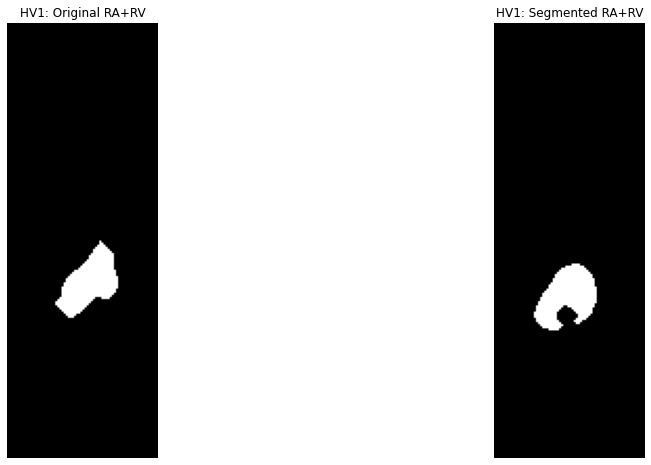

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# HV1 Results
axes[0].imshow(hv1_la_lv, cmap='gray')
axes[0].set_title('HV1: Original RA+RV')
axes[0].axis('off')
axes[1].imshow(hv2_la_lv, cmap='gray')
axes[1].set_title('HV1: Segmented RA+RV')
axes[1].axis('off')

plt.show()


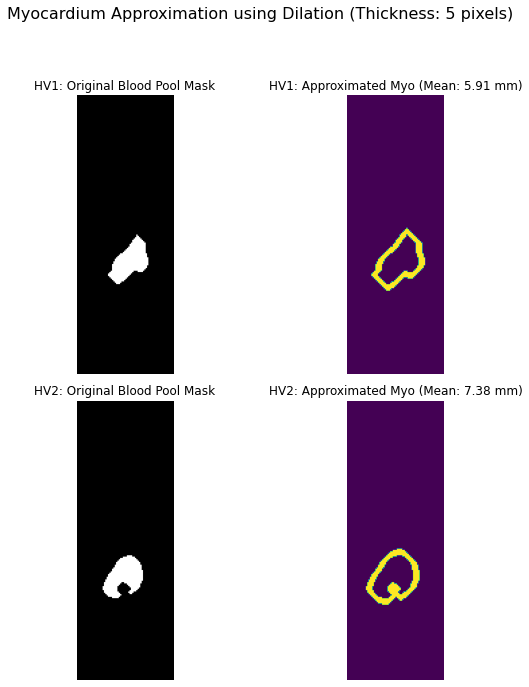

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
from scipy.spatial.distance import cdist

def calculate_thickness_from_mask(mask, resolution_mm):
    """Calculates myocardial thickness from a 2D boolean mask."""
    contours = find_contours(mask, 0.5)
    if len(contours) < 2:
        return None, None
    contours.sort(key=len, reverse=True)
    outer_contour = contours[0]
    inner_contour = contours[1]
    distance_matrix = cdist(inner_contour, outer_contour)
    thickness_in_pixels = distance_matrix.min(axis=1)
    thickness_in_mm = thickness_in_pixels * resolution_mm
    stats = {
        "mean": np.mean(thickness_in_mm),
        "std": np.std(thickness_in_mm),
    }
    return stats, (inner_contour, outer_contour)

def approximate_myocardium(blood_pool_mask, dilation_iterations):
    """
    Creates a myocardial ring approximation using morphological dilation.
    """
    # 1. Make the shape bigger using dilation
    dilated_mask = binary_dilation(blood_pool_mask, iterations=dilation_iterations)
    
    # 2. Subtract the original shape to get the edge/ring
    # This is equivalent to: dilated_mask AND (NOT blood_pool_mask)
    myocardium_approx = dilated_mask & ~blood_pool_mask
    
    return myocardium_approx

# --- Main Script ---

# # --- Create sample data to match your variables ---
# # REPLACE THIS with your actual hv1_la_lv and hv2_la_lv masks
# y, x = np.ogrid[:200, :200]
# hv1_la_lv = (x - 80)**2 + (y - 100)**2 <= 40**2
# hv2_la_lv = (x - 100)**2 + (y - 100)**2 <= 35**2
# # --- End of sample data generation ---


# --- Parameters to Tune ---
# This is the most important parameter. It controls the thickness of the ring.
# It represents the thickness in pixels.
DILATION_ITERATIONS = 5 
RESOLUTION_MM = 1.5 # From project description

# --- Process Volunteer 1 ---
hv1_myo_approx = approximate_myocardium(hv1_la_lv, DILATION_ITERATIONS)
hv1_stats, _ = calculate_thickness_from_mask(hv1_myo_approx, RESOLUTION_MM)

# --- Process Volunteer 2 ---
hv2_myo_approx = approximate_myocardium(hv2_la_lv, DILATION_ITERATIONS)
hv2_stats, _ = calculate_thickness_from_mask(hv2_myo_approx, RESOLUTION_MM)

# --- Plot the results ---
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'Myocardium Approximation using Dilation (Thickness: {DILATION_ITERATIONS} pixels)', fontsize=16)

# Row 1: Volunteer 1
axes[0, 0].imshow(hv1_la_lv, cmap='gray')
axes[0, 0].set_title('HV1: Original Blood Pool Mask')
axes[0, 0].axis('off')

axes[0, 1].imshow(hv1_myo_approx, cmap='viridis')
if hv1_stats:
    axes[0, 1].set_title(f"HV1: Approximated Myo (Mean: {hv1_stats['mean']:.2f} mm)")
axes[0, 1].axis('off')

# Row 2: Volunteer 2
axes[1, 0].imshow(hv2_la_lv, cmap='gray')
axes[1, 0].set_title('HV2: Original Blood Pool Mask')
axes[1, 0].axis('off')

axes[1, 1].imshow(hv2_myo_approx, cmap='viridis')
if hv2_stats:
    axes[1, 1].set_title(f"HV2: Approximated Myo (Mean: {hv2_stats['mean']:.2f} mm)")
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

# Volumen (RA+RV)  y (LA+LV)

In [62]:
pixel_width = 1.5 # mm
pixel_height = 1.5 # mm
area_per_pixel_mm2 = pixel_width * pixel_height

hv1_rv_ra_list = []
hv1_lv_la_list = []
hv2_rv_ra_list = []
hv2_lv_la_list = []

hv1_rv_list = []
hv1_ra_list = []
hv1_lv_list = []
hv1_la_list = []
hv2_rv_list = []
hv2_ra_list = []
hv2_lv_list = []
hv2_la_list = []

plottear = []
plottear_hv = []

# for i in range(HV1_bright.shape[0]):
for i in range(0, 120):
    hv1_bright_slice = HV1_bright[i, :, :]
    hv2_bright_slice = HV2_bright[i, :, :]
    
    plottear_hv.append(hv1_bright_slice)
    
    # Filtro mediana
    hv1_bright_slice_processed = preprocess_slice_median_filter(hv1_bright_slice, filter_size=3)
    hv2_bright_slice_processed = preprocess_slice_median_filter(hv2_bright_slice, filter_size=3)

    # Threshold Otsu
    hv1_directly_segmented_bright_regions_roi_initial = segment_bright_regions_otsu(hv1_bright_slice_processed)
    hv2_directly_segmented_bright_regions_roi_initial = segment_bright_regions_otsu(hv2_bright_slice_processed)

    # Opening
    hv1_refined_roi_mask = refine_binary_mask_opening(hv1_directly_segmented_bright_regions_roi_initial, struct_size=7)
    hv2_refined_roi_mask = refine_binary_mask_opening(hv2_directly_segmented_bright_regions_roi_initial, struct_size=7)

    # Erosion
    hv1_separated_blobs_mask_erosion = apply_binary_erosion(hv1_refined_roi_mask, struct_size=3, iterations=2)
    hv2_separated_blobs_mask_erosion = apply_binary_erosion(hv2_refined_roi_mask, struct_size=3, iterations=2)

    # Label
    hv1_labeled_array, hv1_num_components = label(hv1_separated_blobs_mask_erosion)
    
    areas_hv1 = np.bincount(hv1_labeled_array.ravel())
    areas_hv1[0] = 0 # Ignore the background label 0
    sorted_labels_hv1 = np.argsort(areas_hv1)
    largest_label_hv1 = sorted_labels_hv1[-1]
    hv1_ra_rv = (hv1_labeled_array == largest_label_hv1)
    hv1_ra_rv_segmented = find_best_split(hv1_ra_rv)
    
#     hv1_ra_rv = (hv1_labeled_array == 1)
#     hv1_la_lv = (hv1_labeled_array == 2)

    hv2_labeled_array, hv2_num_components = label(hv2_separated_blobs_mask_erosion)
    
    areas_hv2 = np.bincount(hv2_labeled_array.ravel())
    areas_hv2[0] = 0 # Ignore the background label 0
    sorted_labels_hv2 = np.argsort(areas_hv2)
    largest_label_hv2 = sorted_labels_hv2[-1]
    hv2_ra_rv = (hv2_labeled_array == largest_label_hv2)
    hv2_ra_rv_segmented = find_best_split(hv2_ra_rv)
    
#     hv2_ra_rv = (hv2_labeled_array == 1)
#     hv2_la_lv = (hv2_labeled_array == 3)
    
    if len(sorted_labels_hv1) >= 2:
        second_largest_label_hv1 = sorted_labels_hv1[-2]
        hv1_la_lv = (hv1_labeled_array == second_largest_label_hv1)
        hv1_la_lv_segmented = find_best_split(hv1_la_lv)
    

    if len(sorted_labels_hv2) >= 2:
        second_largest_label_hv2 = sorted_labels_hv2[-2]
        hv2_la_lv = (hv2_labeled_array == second_largest_label_hv2)
        hv2_la_lv_segmented = find_best_split(hv2_la_lv)
    
    # Watershed, para separar (RA+RV) y (LA+LV)
    
#     hv1_ra_rv_segmented = find_best_split(hv1_ra_rv)
#     hv1_la_lv_segmented = find_best_split(hv1_la_lv)
#     hv2_ra_rv_segmented = find_best_split(hv2_ra_rv)
#     hv2_la_lv_segmented = find_best_split(hv2_la_lv)
    
    plottear.append(hv1_ra_rv_segmented)
    
    # Areas individuales
#     hv1_ra_area1, hv1_rv_area2 = calculate_chamber_areas(hv1_ra_rv_segmented)
#     hv1_la_area1, hv1_lv_area2 = calculate_chamber_areas(hv1_la_lv_segmented)
#     hv2_ra_area1, hv2_rv_area2 = calculate_chamber_areas(hv2_ra_rv_segmented)
#     hv2_la_area1, hv2_lv_area2 = calculate_chamber_areas(hv2_la_lv_segmented)

    hv1_rv_area2, hv1_ra_area1 = calculate_chamber_areas(hv1_ra_rv_segmented)
    hv1_lv_area2, hv1_la_area1 = calculate_chamber_areas(hv1_la_lv_segmented)
    hv2_rv_area2, hv2_ra_area1 = calculate_chamber_areas(hv2_ra_rv_segmented)
    hv2_lv_area2, hv2_la_area1 = calculate_chamber_areas(hv2_la_lv_segmented)
    
    hv1_rv_list.append(hv1_rv_area2)
    hv1_ra_list.append(hv1_ra_area1)
    hv1_lv_list.append(hv1_lv_area2)
    hv1_la_list.append(hv1_la_area1)
    hv2_rv_list.append(hv2_rv_area2)
    hv2_ra_list.append(hv2_ra_area1)
    hv2_lv_list.append(hv2_lv_area2)
    hv2_la_list.append(hv2_la_area1)
    
    # Area 2D
    hv1_area_of_component_1_slice = calculate_slice_area(hv1_ra_rv, pixel_width, pixel_height)
    hv1_area_of_component_2_slice = calculate_slice_area(hv1_la_lv, pixel_width, pixel_height)
    hv2_area_of_component_1_slice = calculate_slice_area(hv2_ra_rv, pixel_width, pixel_height)
    hv2_area_of_component_2_slice = calculate_slice_area(hv2_la_lv, pixel_width, pixel_height)
    
    hv1_rv_ra_list.append(hv1_area_of_component_1_slice)
    hv1_lv_la_list.append(hv1_area_of_component_2_slice)
    hv2_rv_ra_list.append(hv2_area_of_component_1_slice)
    hv2_lv_la_list.append(hv2_area_of_component_2_slice)

In [63]:
hv1_rv_ra_acumulado = np.sum(np.array(hv1_rv_ra_list))
hv1_lv_la_acumulado = np.sum(np.array(hv1_lv_la_list))
hv2_rv_ra_acumulado = np.sum(np.array(hv2_rv_ra_list))
hv2_lv_la_acumulado = np.sum(np.array(hv2_lv_la_list))

hv1_rv_acumulado = np.sum(np.array(hv1_rv_list)) * 1.5 / 1000
hv1_ra_acumulado = np.sum(np.array(hv1_ra_list))* 1.5 / 1000
hv1_lv_acumulado = np.sum(np.array(hv1_lv_list))* 1.5 / 1000
hv1_la_acumulado = np.sum(np.array(hv1_la_list))* 1.5 / 1000
hv2_rv_acumulado = np.sum(np.array(hv2_rv_list))* 1.5 / 1000
hv2_ra_acumulado = np.sum(np.array(hv2_ra_list))* 1.5 / 1000
hv2_lv_acumulado = np.sum(np.array(hv2_lv_list))* 1.5 / 1000
hv2_la_acumulado = np.sum(np.array(hv2_la_list))* 1.5 / 1000

### Volumenes HV1 Bright

In [64]:
print(f"Volumen (LV + LA) en mm^3: {hv1_lv_la_acumulado}, en mL: {hv1_lv_la_acumulado/1000}")
# Por mientras, al ojo pareciera que lv = 2/3 y la=1/3
print(f"Volumen LV en mm^3 aproximado: {hv1_lv_la_acumulado*2/3}, en mL: {hv1_lv_la_acumulado*2/3/1000}")
print(f"Volumen LA en mm^3 aproximado: {hv1_lv_la_acumulado*1/3}, en mL: {hv1_lv_la_acumulado*1/3/1000}")

Volumen (LV + LA) en mm^3: 22349.25, en mL: 22.34925
Volumen LV en mm^3 aproximado: 14899.5, en mL: 14.8995
Volumen LA en mm^3 aproximado: 7449.75, en mL: 7.44975


In [65]:
print(f"Volumen (RV + RA) en mm^3: {hv1_rv_ra_acumulado}, en mL: {hv1_rv_ra_acumulado/1000}")
# Por mientras, al ojo pareciera que rv = 3/5 y ra=2/5
print(f"Volumen RV en mm^3 aproximado: {hv1_rv_ra_acumulado*3/5}, en mL: {hv1_rv_ra_acumulado*3/5/1000}")
print(f"Volumen RA en mm^3 aproximado: {hv1_rv_ra_acumulado*2/5}, en mL: {hv1_rv_ra_acumulado*2/5/1000}")

Volumen (RV + RA) en mm^3: 170646.75, en mL: 170.64675
Volumen RV en mm^3 aproximado: 102388.05, en mL: 102.38805
Volumen RA en mm^3 aproximado: 68258.7, en mL: 68.25869999999999


### Volumenes HV2 Bright

In [66]:
print(f"Volumen (LV + LA) en mm^3: {hv2_lv_la_acumulado}, en mL: {hv2_lv_la_acumulado/1000}")
# Por mientras, al ojo pareciera que lv = 2/3 y la=1/3
print(f"Volumen LV en mm^3 aproximado: {hv2_lv_la_acumulado*2/3}, en mL: {hv2_lv_la_acumulado*2/3/1000}")
print(f"Volumen LA en mm^3 aproximado: {hv2_lv_la_acumulado*1/3}, en mL: {hv2_lv_la_acumulado*1/3/1000}")

Volumen (LV + LA) en mm^3: 40383.0, en mL: 40.383
Volumen LV en mm^3 aproximado: 26922.0, en mL: 26.922
Volumen LA en mm^3 aproximado: 13461.0, en mL: 13.461


In [67]:
print(f"Volumen (RV + RA) en mm^3: {hv2_rv_ra_acumulado}, en mL: {hv2_rv_ra_acumulado/1000}")
# Por mientras, al ojo pareciera que rv = 3/5 y ra=2/5
print(f"Volumen RV en mm^3 aproximado: {hv2_rv_ra_acumulado*3/5}, en mL: {hv2_rv_ra_acumulado*3/5/1000}")
print(f"Volumen RA en mm^3 aproximado: {hv2_rv_ra_acumulado*2/5}, en mL: {hv2_rv_ra_acumulado*2/5/1000}")

Volumen (RV + RA) en mm^3: 139988.25, en mL: 139.98825
Volumen RV en mm^3 aproximado: 83992.95, en mL: 83.99295
Volumen RA en mm^3 aproximado: 55995.3, en mL: 55.9953


# Separacion Volumenes.

In [68]:
print(f'Volumen HV1 RV: {hv1_rv_acumulado}')
print(f'Volumen HV1 RA: {hv1_ra_acumulado}')
print(f'Volumen HV1 LV: {hv1_lv_acumulado}')
print(f'Volumen HV1 LA: {hv1_la_acumulado}')
print(f'Volumen HV2 RV: {hv2_rv_acumulado}')
print(f'Volumen HV2 RA: {hv2_ra_acumulado}')
print(f'Volumen HV2 LV: {hv2_lv_acumulado}')
print(f'Volumen HV2 LA: {hv2_la_acumulado}')

Volumen HV1 RV: 131.446125
Volumen HV1 RA: 68.637375
Volumen HV1 LV: 15.035625
Volumen HV1 LA: 8.393625
Volumen HV2 RV: 95.06025
Volumen HV2 RA: 60.68925
Volumen HV2 LV: 35.0055
Volumen HV2 LA: 16.89525


In [ ]:
# 2 mejoras: Saber cuando cortar y encontrar manera automatica de sumar areas bien.